# Quick CNN Training - Ultra Lightweight + Augmentation
## Streamlined version for rapid iteration

This notebook contains only the essential components for training the ultra-lightweight CNN with augmentation and random shuffle split.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.20.0
Keras version: 3.11.3


In [6]:
# Load data - CHANGE THESE PATHS AS NEEDED
df_sensor = pd.read_csv('../concept_labeling_outputs/iteration3/merged_dataset_with_concepts.csv')
df_windows = pd.read_csv('../concept_labeling_outputs/iteration3/merged_window_labels.csv')

print(f"Sensor data: {len(df_sensor)} readings")
print(f"Manual labels: {len(df_windows)} windows")
print(f"\nLabeled windows:")
print(df_windows.head())

Sensor data: 5862 readings
Manual labels: 100 windows

Labeled windows:
   window_idx  user activity  start_time  end_time  periodicity  \
0           0     3  Walking      957.75    960.75          1.0   
1           1     3  Walking       42.00     45.00          1.0   
2           2     3  Walking      871.50    874.50          0.5   
3           3     3  Walking       63.00     66.00          1.0   
4           4     3  Jogging      117.75    120.75          1.0   

   temporal_stability  coordination  
0                 0.5           0.5  
1                 0.5           0.5  
2                 0.5           0.5  
3                 0.5           0.5  
4                 0.5           0.5  


In [7]:
def extract_window_robust(df_sensor, window_row, time_tolerance=0.5):
    """
    Extract sensor data with time tolerance to handle mismatches.
    """
    user = window_row['user']
    activity = window_row['activity']
    start_time = window_row['start_time']
    end_time = window_row['end_time']
    
    # Get data for this user/activity
    user_activity_data = df_sensor[(df_sensor['user'] == user) & 
                                  (df_sensor['activity'] == activity)].copy()
    
    if len(user_activity_data) == 0:
        return None
    
    # Find data within time window with tolerance
    mask = ((user_activity_data['time_s'] >= start_time - time_tolerance) & 
            (user_activity_data['time_s'] <= end_time + time_tolerance))
    
    window_data = user_activity_data[mask]
    
    if len(window_data) < 10:  # Need minimum samples
        return None
    
    # Extract sensor readings
    sensor_data = window_data[['x-axis', 'y-axis', 'z-axis']].values
    
    # Pad or truncate to fixed length (e.g., 100 samples)
    target_length = 100
    if len(sensor_data) > target_length:
        # Randomly sample if too long
        indices = np.random.choice(len(sensor_data), target_length, replace=False)
        sensor_data = sensor_data[indices]
    elif len(sensor_data) < target_length:
        # Pad with last value if too short
        padding = np.tile(sensor_data[-1:], (target_length - len(sensor_data), 1))
        sensor_data = np.vstack([sensor_data, padding])
    
    return sensor_data

def extract_windows_robust(df_sensor, df_windows):
    """
    Extract all windows with robust time matching.
    """
    X = []
    y_p = []
    y_t = []
    y_c = []
    
    for _, window_row in df_windows.iterrows():
        window_data = extract_window_robust(df_sensor, window_row)
        if window_data is not None:
            X.append(window_data)
            y_p.append(window_row['periodicity'])
            y_t.append(window_row['temporal_stability'])
            y_c.append(window_row['coordination'])
    
    return np.array(X), np.array(y_p), np.array(y_t), np.array(y_c)

In [8]:
def augment_jitter(data, sigma=0.05):
    """Add random Gaussian noise to simulate sensor imperfections"""
    return data + np.random.normal(0, sigma, data.shape)

def augment_scaling(data, sigma=0.1):
    """Scale magnitude to simulate different movement intensities"""
    # Handle different data shapes
    if len(data.shape) == 3:
        factor = np.random.normal(1.0, sigma, (data.shape[0], 1, data.shape[2]))
    elif len(data.shape) == 2:
        factor = np.random.normal(1.0, sigma, (data.shape[0], data.shape[1]))
    else:
        factor = np.random.normal(1.0, sigma, data.shape)
    return data * factor

def augment_rotation(data):
    """Rotate 3D data to simulate different phone orientations"""
    angle = np.random.uniform(-np.pi/6, np.pi/6)  # ±30 degrees
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    rotation_matrix = np.array([
        [cos_a, -sin_a, 0],
        [sin_a, cos_a, 0],
        [0, 0, 1]
    ])
    return np.dot(data, rotation_matrix.T)

def augment_dataset(X, y_p, y_t, y_c, factor=10):
    """
    Create augmented versions of the dataset.
    
    Args:
        X: Original data (n_samples, timesteps, 3)
        y_p, y_t, y_c: Labels for three concepts
        factor: Augmentation multiplier (10 = 10x more data)
    
    Returns:
        Augmented dataset with (factor+1) × original size
    """
    n_original = len(X)
    n_augmented = n_original * factor
    
    # Initialize augmented arrays
    X_aug = np.zeros((n_augmented, X.shape[1], X.shape[2]))
    y_p_aug = np.zeros(n_augmented)
    y_t_aug = np.zeros(n_augmented)
    y_c_aug = np.zeros(n_augmented)
    
    for i in range(n_augmented):
        # Randomly select original sample
        idx = np.random.randint(0, n_original)
        
        # Apply random augmentation
        aug_type = np.random.choice(['jitter', 'scaling', 'rotation', 'none'])
        
        if aug_type == 'jitter':
            X_aug[i] = augment_jitter(X[idx])
        elif aug_type == 'scaling':
            X_aug[i] = augment_scaling(X[idx])
        elif aug_type == 'rotation':
            X_aug[i] = augment_rotation(X[idx])
        else:  # none
            X_aug[i] = X[idx]
        
        # Copy labels
        y_p_aug[i] = y_p[idx]
        y_t_aug[i] = y_t[idx]
        y_c_aug[i] = y_c[idx]
    
    # Combine original and augmented data
    X_combined = np.vstack([X, X_aug])
    y_p_combined = np.concatenate([y_p, y_p_aug])
    y_t_combined = np.concatenate([y_t, y_t_aug])
    y_c_combined = np.concatenate([y_c, y_c_aug])
    
    return X_combined, y_p_combined, y_t_combined, y_c_combined

In [9]:
# OPTIMIZED MODEL WITH BEST GRID SEARCH PARAMETERS
def build_optimized_cnn(input_shape, n_classes_p, n_classes_t, n_classes_c):
    """
    Optimized CNN using best parameters from grid search:
    - conv_filters_1: 16, conv_filters_2: 16
    - dropout_rate: 0.4
    - learning_rate: 0.001 (will be set in compile)
    - batch_size: 32 (will be set in fit)
    """
    input_layer = layers.Input(shape=input_shape)
    
    # Conv layer 1 (optimized: 16 filters)
    x = layers.Conv1D(16, 3, activation='relu', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    
    # Conv layer 2 (optimized: 16 filters)
    x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    
    # Dropout (optimized: 0.4)
    x = layers.Dropout(0.4)(x)
    
    # Output heads for each concept
    periodicity = layers.Dense(n_classes_p, activation='softmax', name='periodicity')(x)
    temporal_stability = layers.Dense(n_classes_t, activation='softmax', name='temporal_stability')(x)
    coordination = layers.Dense(n_classes_c, activation='softmax', name='coordination')(x)
    
    model = models.Model(inputs=input_layer, outputs=[periodicity, temporal_stability, coordination])
    
    return model


In [10]:
# def build_lightweight_cnn(input_shape, n_classes_p, n_classes_t, n_classes_c):
#     """
#     Ultra-lightweight CNN designed for very small datasets (~75 samples).
#     - Only 2 conv layers
#     - Minimal filters (16, 32)
#     - Low dropout
#     - ~2-3K parameters total
#     """
#     input_layer = layers.Input(shape=input_shape)
    
#     # Conv layer 1
#     x = layers.Conv1D(16, 3, activation='relu', padding='same')(input_layer)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling1D(2)(x)
    
#     # Conv layer 2
#     x = layers.Conv1D(32, 3, activation='relu', padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.GlobalAveragePooling1D()(x)
    
#     # Dropout
#     x = layers.Dropout(0.3)(x)
    
#     # Output heads for each concept
#     periodicity = layers.Dense(n_classes_p, activation='softmax', name='periodicity')(x)
#     temporal_stability = layers.Dense(n_classes_t, activation='softmax', name='temporal_stability')(x)
#     coordination = layers.Dense(n_classes_c, activation='softmax', name='coordination')(x)
    
#     model = models.Model(inputs=input_layer, outputs=[periodicity, temporal_stability, coordination])
    
#     return model

In [11]:
# Extract windows
print("Extracting windows...")
X, y_p, y_t, y_c = extract_windows_robust(df_sensor, df_windows)

print(f"Extracted {len(X)} windows")
print(f"Window shape: {X.shape}")
print(f"Label distributions:")
print(f"  Periodicity: {np.bincount(y_p.astype(int))}")
print(f"  Temporal Stability: {np.bincount(y_t.astype(int))}")
print(f"  Coordination: {np.bincount(y_c.astype(int))}")

Extracting windows...
Extracted 100 windows
Window shape: (100, 100, 3)
Label distributions:
  Periodicity: [80 20]
  Temporal Stability: [70 30]
  Coordination: [51 49]


In [12]:
# Random shuffle split (75% train, 25% test)
print("Splitting data...")
X_train, X_test, y_p_train, y_p_test, y_t_train, y_t_test, y_c_train, y_c_test = train_test_split(
    X, y_p, y_t, y_c, test_size=0.25, random_state=42, stratify=None
)

print(f"Train: {len(X_train)} windows")
print(f"Test: {len(X_test)} windows")

Splitting data...
Train: 75 windows
Test: 25 windows


In [13]:
# Apply augmentation
print("Augmenting training data...")
X_train_aug, y_p_train_aug, y_t_train_aug, y_c_train_aug = augment_dataset(
    X_train, y_p_train, y_t_train, y_c_train, factor=10
)

print(f"Original train: {len(X_train)} windows")
print(f"Augmented train: {len(X_train_aug)} windows")
print(f"Augmentation factor: {len(X_train_aug) / len(X_train):.1f}x")

Augmenting training data...
Original train: 75 windows
Augmented train: 825 windows
Augmentation factor: 11.0x


In [14]:
# Convert labels to categorical
y_p_train_cat = to_categorical(y_p_train_aug * 2, num_classes=3)
y_t_train_cat = to_categorical(y_t_train_aug * 2, num_classes=3)
y_c_train_cat = to_categorical(y_c_train_aug * 2, num_classes=3)

y_p_test_cat = to_categorical(y_p_test * 2, num_classes=3)
y_t_test_cat = to_categorical(y_t_test * 2, num_classes=3)
y_c_test_cat = to_categorical(y_c_test * 2, num_classes=3)

print("Labels converted to categorical format")

Labels converted to categorical format


In [15]:
# Build and compile model
print("Building model...")
model = build_optimized_cnn(
    input_shape=(X_train_aug.shape[1], X_train_aug.shape[2]),
    n_classes_p=3, n_classes_t=3, n_classes_c=3
)

# Compile with appropriate loss weights
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        'periodicity': 'categorical_crossentropy',
        'temporal_stability': 'categorical_crossentropy',
        'coordination': 'categorical_crossentropy'
    },
    loss_weights={'periodicity': 1.0, 'temporal_stability': 1.0, 'coordination': 1.0},
    metrics={
        'periodicity': ['accuracy'],
        'temporal_stability': ['accuracy'],
        'coordination': ['accuracy']
    }
)

print(f"Model parameters: {model.count_params():,}")
model.summary()

Building model...
Model parameters: 1,225


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 16)   │        160 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 16)   │         64 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 50, 16)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 50, 16)    │        784 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 16)    │         64 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ periodicity (Dense) │ (None, 3)         │         51 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temporal_stability  │ (None, 3)         │         51 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coordination        │ (None, 3)         │         51 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,225 (4.79 KB)

 Trainable params: 1,161 (4.54 KB)

 Non-trainable params: 64 (256.00 B)

In [16]:
# Train model
print("Training model...")
history = model.fit(
    X_train_aug,
    [y_p_train_cat, y_t_train_cat, y_c_train_cat],
    validation_data=(X_test, [y_p_test_cat, y_t_test_cat, y_c_test_cat]),
    epochs=100,
    batch_size=32,  # Optimized parameter from grid search
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ]
)

print("Training completed!")

Training model...
Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - coordination_accuracy: 0.4667 - coordination_loss: 1.1196 - loss: 3.4391 - periodicity_accuracy: 0.4194 - periodicity_loss: 1.1923 - temporal_stability_accuracy: 0.4521 - temporal_stability_loss: 1.1216 - val_coordination_accuracy: 0.2400 - val_coordination_loss: 1.3575 - val_loss: 4.1202 - val_periodicity_accuracy: 0.2400 - val_periodicity_loss: 1.8683 - val_temporal_stability_accuracy: 0.6400 - val_temporal_stability_loss: 0.8944 - learning_rate: 0.0010
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - coordination_accuracy: 0.5394 - coordination_loss: 0.9824 - loss: 2.8972 - periodicity_accuracy: 0.5442 - periodicity_loss: 0.9759 - temporal_stability_accuracy: 0.5612 - temporal_stability_loss: 0.9371 - val_coordination_accuracy: 0.3600 - val_coordination_loss: 1.0388 - val_loss: 3.4871 - val_periodicity_accuracy: 0.3200 - val_periodicity_loss: 1.5651 - val_temporal_stability_accuracy: 0.7200 - val_temporal_st

In [17]:
# Evaluate model
print("Evaluating model...")
results = model.evaluate(X_test, [y_p_test_cat, y_t_test_cat, y_c_test_cat], verbose=0)

# Extract accuracies - the structure is: [total_loss, periodicity_loss, temporal_stability_loss, coordination_loss, periodicity_acc, temporal_stability_acc, coordination_acc]
if len(results) >= 7:
    periodicity_acc = results[4]
    temporal_stability_acc = results[5] 
    coordination_acc = results[6]
    overall_acc = (periodicity_acc + temporal_stability_acc + coordination_acc) / 3
else:
    print("Unexpected results structure, using alternative approach...")
    # Alternative: Get predictions and calculate accuracy manually
    predictions = model.predict(X_test, verbose=0)
    periodicity_pred = np.argmax(predictions[0], axis=1)
    temporal_stability_pred = np.argmax(predictions[1], axis=1)
    coordination_pred = np.argmax(predictions[2], axis=1)
    
    periodicity_acc = accuracy_score(np.argmax(y_p_test_cat, axis=1), periodicity_pred)
    temporal_stability_acc = accuracy_score(np.argmax(y_t_test_cat, axis=1), temporal_stability_pred)
    coordination_acc = accuracy_score(np.argmax(y_c_test_cat, axis=1), coordination_pred)
    overall_acc = (periodicity_acc + temporal_stability_acc + coordination_acc) / 3

print(f"\n=== RESULTS ===")
print(f"Periodicity Accuracy: {periodicity_acc:.4f}")
print(f"Temporal Stability Accuracy: {temporal_stability_acc:.4f}")
print(f"Coordination Accuracy: {coordination_acc:.4f}")
print(f"\nOverall Average Accuracy: {overall_acc*100:.1f}%")

Evaluating model...

=== RESULTS ===
Periodicity Accuracy: 0.8000
Temporal Stability Accuracy: 0.6800
Coordination Accuracy: 0.8000

Overall Average Accuracy: 76.0%


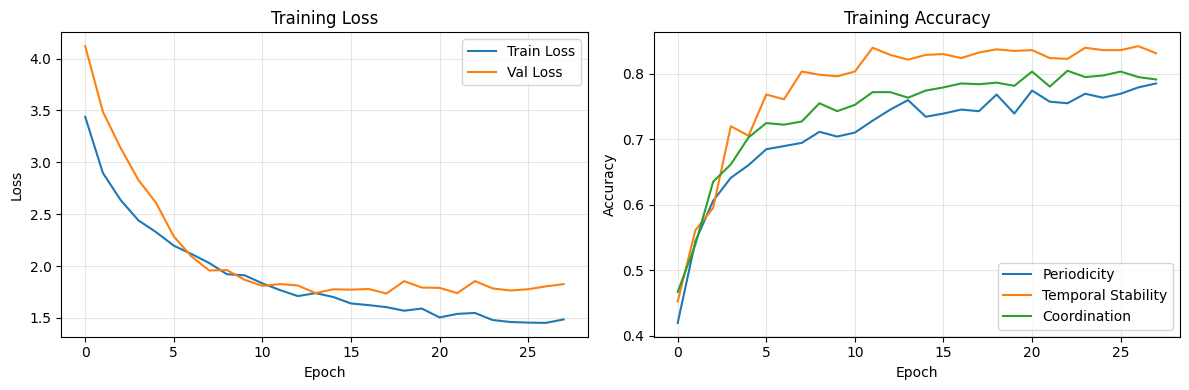


Final Accuracy: 76.0%


In [18]:
# Quick visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.history['periodicity_accuracy'], label='Periodicity')
axes[1].plot(history.history['temporal_stability_accuracy'], label='Temporal Stability')
axes[1].plot(history.history['coordination_accuracy'], label='Coordination')
axes[1].set_title('Training Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Accuracy: {overall_acc*100:.1f}%")

In [19]:
# # Hyperparameter Grid Search
# from sklearn.model_selection import ParameterGrid
# from sklearn.metrics import classification_report, f1_score, recall_score, precision_score
# import time

# def evaluate_model_comprehensive(model, X_test, y_p_test, y_t_test, y_c_test, y_p_test_cat, y_t_test_cat, y_c_test_cat):
#     """Evaluate model with comprehensive metrics"""
#     # Get predictions
#     predictions = model.predict(X_test, verbose=0)
#     periodicity_pred = np.argmax(predictions[0], axis=1)
#     temporal_stability_pred = np.argmax(predictions[1], axis=1)
#     coordination_pred = np.argmax(predictions[2], axis=1)
    
#     # True labels
#     periodicity_true = np.argmax(y_p_test_cat, axis=1)
#     temporal_stability_true = np.argmax(y_t_test_cat, axis=1)
#     coordination_true = np.argmax(y_c_test_cat, axis=1)
    
#     # Calculate metrics for each concept
#     metrics = {}
#     for concept, pred, true in [('periodicity', periodicity_pred, periodicity_true),
#                                ('temporal_stability', temporal_stability_pred, temporal_stability_true),
#                                ('coordination', coordination_pred, coordination_true)]:
#         metrics[f'{concept}_accuracy'] = accuracy_score(true, pred)
#         metrics[f'{concept}_f1'] = f1_score(true, pred, average='weighted')
#         metrics[f'{concept}_recall'] = recall_score(true, pred, average='weighted')
#         metrics[f'{concept}_precision'] = precision_score(true, pred, average='weighted')
    
#     # Overall metrics
#     metrics['overall_accuracy'] = (metrics['periodicity_accuracy'] + 
#                                   metrics['temporal_stability_accuracy'] + 
#                                   metrics['coordination_accuracy']) / 3
#     metrics['overall_f1'] = (metrics['periodicity_f1'] + 
#                             metrics['temporal_stability_f1'] + 
#                             metrics['coordination_f1']) / 3
    
#     return metrics

# # Define hyperparameter grid
# param_grid = {
#     'learning_rate': [0.001, 0.0005, 0.0001],
#     'batch_size': [16, 32],
#     'dropout_rate': [0.2, 0.3, 0.4],
#     'conv_filters_1': [8, 16, 32],
#     'conv_filters_2': [16, 32, 64]
# }

# print(f"Grid search will test {len(list(ParameterGrid(param_grid)))} combinations")
# print("This may take a while...")

# # Store results
# grid_results = []
# best_score = 0
# best_params = None

# # Grid search
# for i, params in enumerate(ParameterGrid(param_grid)):
#     print(f"\n--- Testing combination {i+1}/{len(list(ParameterGrid(param_grid)))} ---")
#     print(f"Params: {params}")
    
#     # Build model with current parameters
#     def build_custom_cnn(input_shape, n_classes_p, n_classes_t, n_classes_c, 
#                         conv_filters_1, conv_filters_2, dropout_rate):
#         input_layer = layers.Input(shape=input_shape)
        
#         # Conv layer 1
#         x = layers.Conv1D(conv_filters_1, 3, activation='relu', padding='same')(input_layer)
#         x = layers.BatchNormalization()(x)
#         x = layers.MaxPooling1D(2)(x)
        
#         # Conv layer 2
#         x = layers.Conv1D(conv_filters_2, 3, activation='relu', padding='same')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.GlobalAveragePooling1D()(x)
        
#         # Dropout
#         x = layers.Dropout(dropout_rate)(x)
        
#         # Output heads
#         periodicity = layers.Dense(n_classes_p, activation='softmax', name='periodicity')(x)
#         temporal_stability = layers.Dense(n_classes_t, activation='softmax', name='temporal_stability')(x)
#         coordination = layers.Dense(n_classes_c, activation='softmax', name='coordination')(x)
        
#         return models.Model(inputs=input_layer, outputs=[periodicity, temporal_stability, coordination])
    
#     # Create model
#     model = build_custom_cnn(
#         input_shape=(X_train_aug.shape[1], X_train_aug.shape[2]),
#         n_classes_p=3, n_classes_t=3, n_classes_c=3,
#         conv_filters_1=params['conv_filters_1'],
#         conv_filters_2=params['conv_filters_2'],
#         dropout_rate=params['dropout_rate']
#     )
    
#     # Compile model
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']),
#         loss={
#             'periodicity': 'categorical_crossentropy',
#             'temporal_stability': 'categorical_crossentropy',
#             'coordination': 'categorical_crossentropy'
#         },
#         loss_weights={'periodicity': 1.0, 'temporal_stability': 1.0, 'coordination': 1.0},
#         metrics={
#             'periodicity': ['accuracy'],
#             'temporal_stability': ['accuracy'],
#             'coordination': ['accuracy']
#         }
#     )
    
#     # Train model (shorter training for grid search)
#     start_time = time.time()
#     history = model.fit(
#         X_train_aug,
#         [y_p_train_cat, y_t_train_cat, y_c_train_cat],
#         validation_data=(X_test, [y_p_test_cat, y_t_test_cat, y_c_test_cat]),
#         epochs=30,  # Reduced for speed
#         batch_size=params['batch_size'],
#         verbose=0,
#         callbacks=[
#             keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
#         ]
#     )
    
#     # Evaluate model
#     metrics = evaluate_model_comprehensive(
#         model, X_test, y_p_test, y_t_test, y_c_test,
#         y_p_test_cat, y_t_test_cat, y_c_test_cat
#     )
    
#     # Store results
#     result = {
#         'params': params,
#         'overall_accuracy': metrics['overall_accuracy'],
#         'overall_f1': metrics['overall_f1'],
#         'periodicity_accuracy': metrics['periodicity_accuracy'],
#         'temporal_stability_accuracy': metrics['temporal_stability_accuracy'],
#         'coordination_accuracy': metrics['coordination_accuracy'],
#         'periodicity_f1': metrics['periodicity_f1'],
#         'temporal_stability_f1': metrics['temporal_stability_f1'],
#         'coordination_f1': metrics['coordination_f1'],
#         'periodicity_recall': metrics['periodicity_recall'],
#         'temporal_stability_recall': metrics['temporal_stability_recall'],
#         'coordination_recall': metrics['coordination_recall'],
#         'training_time': time.time() - start_time
#     }
    
#     grid_results.append(result)
    
#     print(f"Overall Accuracy: {metrics['overall_accuracy']:.4f}")
#     print(f"Overall F1: {metrics['overall_f1']:.4f}")
#     print(f"Training time: {result['training_time']:.1f}s")
    
#     # Track best model
#     if metrics['overall_accuracy'] > best_score:
#         best_score = metrics['overall_accuracy']
#         best_params = params
#         print("*** NEW BEST MODEL ***")

# print(f"\n=== GRID SEARCH COMPLETE ===")
# print(f"Best accuracy: {best_score:.4f}")
# print(f"Best parameters: {best_params}")


In [20]:
# # Analyze Grid Search Results
# import pandas as pd

# # Convert results to DataFrame for analysis
# results_df = pd.DataFrame(grid_results)

# print("=== GRID SEARCH RESULTS ANALYSIS ===")
# print(f"Total combinations tested: {len(results_df)}")
# print(f"Best overall accuracy: {results_df['overall_accuracy'].max():.4f}")
# print(f"Best overall F1 score: {results_df['overall_f1'].max():.4f}")

# # Top 5 models by accuracy
# print("\n=== TOP 5 MODELS BY ACCURACY ===")
# top_models = results_df.nlargest(5, 'overall_accuracy')[['params', 'overall_accuracy', 'overall_f1', 'training_time']]
# for idx, row in top_models.iterrows():
#     print(f"Accuracy: {row['overall_accuracy']:.4f}, F1: {row['overall_f1']:.4f}, Time: {row['training_time']:.1f}s")
#     print(f"  Params: {row['params']}")
#     print()

# # Parameter importance analysis - FIXED VERSION
# print("=== PARAMETER IMPORTANCE ===")

# # Extract parameters from the nested 'params' column
# param_data = []
# for idx, row in results_df.iterrows():
#     param_row = row['params'].copy()
#     param_row['overall_accuracy'] = row['overall_accuracy']
#     param_row['overall_f1'] = row['overall_f1']
#     param_row['training_time'] = row['training_time']
#     param_data.append(param_row)

# param_df = pd.DataFrame(param_data)

# for param in ['learning_rate', 'batch_size', 'dropout_rate', 'conv_filters_1', 'conv_filters_2']:
#     param_analysis = param_df.groupby(param)['overall_accuracy'].agg(['mean', 'std', 'count'])
#     print(f"\n{param}:")
#     print(param_analysis.round(4))

# # Detailed metrics for best model
# best_idx = results_df['overall_accuracy'].idxmax()
# best_model = results_df.iloc[best_idx]

# print(f"\n=== BEST MODEL DETAILED METRICS ===")
# print(f"Parameters: {best_model['params']}")
# print(f"Overall Accuracy: {best_model['overall_accuracy']:.4f}")
# print(f"Overall F1: {best_model['overall_f1']:.4f}")
# print(f"Training Time: {best_model['training_time']:.1f}s")
# print()
# print("Per-concept metrics:")
# print(f"  Periodicity - Accuracy: {best_model['periodicity_accuracy']:.4f}, F1: {best_model['periodicity_f1']:.4f}, Recall: {best_model['periodicity_recall']:.4f}")
# print(f"  Temporal Stability - Accuracy: {best_model['temporal_stability_accuracy']:.4f}, F1: {best_model['temporal_stability_f1']:.4f}, Recall: {best_model['temporal_stability_recall']:.4f}")
# print(f"  Coordination - Accuracy: {best_model['coordination_accuracy']:.4f}, F1: {best_model['coordination_f1']:.4f}, Recall: {best_model['coordination_recall']:.4f}")

# # Visualization - FIXED VERSION
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# # Accuracy vs parameters using the flattened param_df
# param_names = ['learning_rate', 'batch_size', 'dropout_rate', 'conv_filters_1', 'conv_filters_2']
# for i, param in enumerate(param_names):
#     if i < 5:
#         row, col = i // 3, i % 3
#         if row < 2 and col < 3:
#             param_values = param_df.groupby(param)['overall_accuracy'].mean()
#             axes[row, col].plot(param_values.index, param_values.values, 'o-')
#             axes[row, col].set_title(f'Accuracy vs {param}')
#             axes[row, col].set_xlabel(param)
#             axes[row, col].set_ylabel('Overall Accuracy')
#             axes[row, col].grid(True, alpha=0.3)

# # Remove empty subplot
# if len(param_names) < 6:
#     axes[1, 2].remove()

# plt.tight_layout()
# plt.show()

# # Save results
# results_df.to_csv('grid_search_results.csv', index=False)
# print(f"\nResults saved to 'grid_search_results.csv'")


In [21]:
# Deep Dive Analysis: Understanding Performance Variability
# This cell helps analyze why certain random splits perform much better/worse

# Import required functions
from sklearn.model_selection import train_test_split

def analyze_split_quality(X_train, X_test, y_p_train, y_p_test, y_t_train, y_t_test, y_c_train, y_c_test):
    """Analyze the quality of a specific train/test split"""
    
    print("=== SPLIT QUALITY ANALYSIS ===")
    
    # 1. Label Distribution Analysis
    print("\n1. LABEL DISTRIBUTION:")
    for concept, train_labels, test_labels in [('Periodicity', y_p_train, y_p_test),
                                             ('Temporal Stability', y_t_train, y_t_test),
                                             ('Coordination', y_c_train, y_c_test)]:
        train_dist = np.bincount(train_labels.astype(int))
        test_dist = np.bincount(test_labels.astype(int))
        
        print(f"\n{concept}:")
        print(f"  Train: {train_dist} (ratios: {train_dist/train_dist.sum()})")
        print(f"  Test:  {test_dist} (ratios: {test_dist/test_dist.sum()})")
        
        # Check for class imbalance
        train_imbalance = np.max(train_dist) / np.min(train_dist)
        test_imbalance = np.max(test_dist) / np.min(test_dist)
        print(f"  Train imbalance ratio: {train_imbalance:.2f}")
        print(f"  Test imbalance ratio: {test_imbalance:.2f}")
    
    # 2. Data Quality Analysis
    print("\n2. DATA QUALITY:")
    
    # Signal variance analysis
    train_variance = np.var(X_train, axis=(1,2)).mean()
    test_variance = np.var(X_test, axis=(1,2)).mean()
    print(f"Average signal variance:")
    print(f"  Train: {train_variance:.6f}")
    print(f"  Test:  {test_variance:.6f}")
    print(f"  Ratio: {test_variance/train_variance:.3f}")
    
    # Signal magnitude analysis
    train_magnitude = np.mean(np.sqrt(np.sum(X_train**2, axis=2)), axis=1).mean()
    test_magnitude = np.mean(np.sqrt(np.sum(X_test**2, axis=2)), axis=1).mean()
    print(f"Average signal magnitude:")
    print(f"  Train: {train_magnitude:.6f}")
    print(f"  Test:  {test_magnitude:.6f}")
    print(f"  Ratio: {test_magnitude/train_magnitude:.3f}")
    
    # 3. Concept Difficulty Analysis
    print("\n3. CONCEPT DIFFICULTY:")
    
    # Calculate concept correlation
    concepts_corr = np.corrcoef([y_p_train, y_t_train, y_c_train])
    print("Concept correlations in training data:")
    concept_names = ['Periodicity', 'Temporal Stability', 'Coordination']
    for i in range(3):
        for j in range(i+1, 3):
            print(f"  {concept_names[i]} vs {concept_names[j]}: {concepts_corr[i,j]:.3f}")
    
    # 4. Window Quality Analysis
    print("\n4. WINDOW QUALITY:")
    
    # Check for windows with very low/high activity
    train_activity = np.mean(np.sqrt(np.sum(X_train**2, axis=2)), axis=1)
    test_activity = np.mean(np.sqrt(np.sum(X_test**2, axis=2)), axis=1)
    
    print(f"Activity levels:")
    print(f"  Train - Min: {train_activity.min():.3f}, Max: {train_activity.max():.3f}, Std: {train_activity.std():.3f}")
    print(f"  Test  - Min: {test_activity.min():.3f}, Max: {test_activity.max():.3f}, Std: {test_activity.std():.3f}")
    
    # Check for potential outliers
    train_outliers = np.sum((train_activity < train_activity.mean() - 2*train_activity.std()) | 
                           (train_activity > train_activity.mean() + 2*train_activity.std()))
    test_outliers = np.sum((test_activity < test_activity.mean() - 2*test_activity.std()) | 
                          (test_activity > test_activity.mean() + 2*test_activity.std()))
    
    print(f"Potential outliers (2σ rule):")
    print(f"  Train: {train_outliers}/{len(train_activity)} ({100*train_outliers/len(train_activity):.1f}%)")
    print(f"  Test:  {test_outliers}/{len(test_activity)} ({100*test_outliers/len(test_activity):.1f}%)")
    
    return {
        'train_variance': train_variance,
        'test_variance': test_variance,
        'train_magnitude': train_magnitude,
        'test_magnitude': test_magnitude,
        'train_activity': train_activity,
        'test_activity': test_activity,
        'concepts_corr': concepts_corr
    }

def run_multiple_splits_analysis(n_splits=10):
    """Run multiple random splits to understand variability"""
    
    print(f"=== MULTIPLE SPLITS ANALYSIS ({n_splits} splits) ===")
    
    split_results = []
    
    for split_idx in range(n_splits):
        print(f"\n--- Split {split_idx + 1}/{n_splits} ---")
        
        # Create new split
        X_train, X_test, y_p_train, y_p_test, y_t_train, y_t_test, y_c_train, y_c_test = train_test_split(
            X, y_p, y_t, y_c, test_size=0.25, random_state=42+split_idx, stratify=None
        )
        
        # Analyze this split
        split_analysis = analyze_split_quality(X_train, X_test, y_p_train, y_p_test, y_t_train, y_t_test, y_c_train, y_c_test)
        
        # Train a quick model to get performance
        print("\nTraining quick model...")
        
        # Convert to categorical
        y_p_train_cat = to_categorical(y_p_train * 2, num_classes=3)
        y_t_train_cat = to_categorical(y_t_train * 2, num_classes=3)
        y_c_train_cat = to_categorical(y_c_train * 2, num_classes=3)
        y_p_test_cat = to_categorical(y_p_test * 2, num_classes=3)
        y_t_test_cat = to_categorical(y_t_test * 2, num_classes=3)
        y_c_test_cat = to_categorical(y_c_test * 2, num_classes=3)
        
        # Augment training data
        X_train_aug, y_p_train_aug, y_t_train_aug, y_c_train_aug = augment_dataset(
            X_train, y_p_train, y_t_train, y_c_train, factor=5  # Reduced for speed
        )
        
        # Convert augmented labels
        y_p_train_cat_aug = to_categorical(y_p_train_aug * 2, num_classes=3)
        y_t_train_cat_aug = to_categorical(y_t_train_aug * 2, num_classes=3)
        y_c_train_cat_aug = to_categorical(y_c_train_aug * 2, num_classes=3)
        
        # Build and train model
        model = build_optimized_cnn(
            input_shape=(X_train_aug.shape[1], X_train_aug.shape[2]),
            n_classes_p=3, n_classes_t=3, n_classes_c=3
        )
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss={
                'periodicity': 'categorical_crossentropy',
                'temporal_stability': 'categorical_crossentropy',
                'coordination': 'categorical_crossentropy'
            },
            loss_weights={'periodicity': 1.0, 'temporal_stability': 1.0, 'coordination': 1.0},
            metrics={
                'periodicity': ['accuracy'],
                'temporal_stability': ['accuracy'],
                'coordination': ['accuracy']
            }
        )
        
        # Quick training
        history = model.fit(
            X_train_aug,
            [y_p_train_cat_aug, y_t_train_cat_aug, y_c_train_cat_aug],
            validation_data=(X_test, [y_p_test_cat, y_t_test_cat, y_c_test_cat]),
            epochs=20,
            batch_size=16,
            verbose=0,
            callbacks=[keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
        )
        
        # Evaluate
        results = model.evaluate(X_test, [y_p_test_cat, y_t_test_cat, y_c_test_cat], verbose=0)
        overall_acc = (results[4] + results[5] + results[6]) / 3
        
        print(f"Overall Accuracy: {overall_acc:.4f}")
        
        # Store results
        split_results.append({
            'split_idx': split_idx,
            'accuracy': overall_acc,
            'train_variance': split_analysis['train_variance'],
            'test_variance': split_analysis['test_variance'],
            'variance_ratio': split_analysis['test_variance'] / split_analysis['train_variance'],
            'train_magnitude': split_analysis['train_magnitude'],
            'test_magnitude': split_analysis['test_magnitude'],
            'magnitude_ratio': split_analysis['test_magnitude'] / split_analysis['train_magnitude'],
            'train_activity_std': split_analysis['train_activity'].std(),
            'test_activity_std': split_analysis['test_activity'].std(),
            'activity_std_ratio': split_analysis['test_activity'].std() / split_analysis['train_activity'].std()
        })
    
    # Analyze results
    results_df = pd.DataFrame(split_results)
    
    print(f"\n=== VARIABILITY ANALYSIS ===")
    print(f"Accuracy range: {results_df['accuracy'].min():.4f} - {results_df['accuracy'].max():.4f}")
    print(f"Accuracy std: {results_df['accuracy'].std():.4f}")
    print(f"Accuracy mean: {results_df['accuracy'].mean():.4f}")
    
    # Find best and worst splits
    best_split = results_df.loc[results_df['accuracy'].idxmax()]
    worst_split = results_df.loc[results_df['accuracy'].idxmin()]
    
    print(f"\nBEST SPLIT (accuracy: {best_split['accuracy']:.4f}):")
    print(f"  Variance ratio: {best_split['variance_ratio']:.3f}")
    print(f"  Magnitude ratio: {best_split['magnitude_ratio']:.3f}")
    print(f"  Activity std ratio: {best_split['activity_std_ratio']:.3f}")
    
    print(f"\nWORST SPLIT (accuracy: {worst_split['accuracy']:.4f}):")
    print(f"  Variance ratio: {worst_split['variance_ratio']:.3f}")
    print(f"  Magnitude ratio: {worst_split['magnitude_ratio']:.3f}")
    print(f"  Activity std ratio: {worst_split['activity_std_ratio']:.3f}")
    
    # Correlation analysis
    print(f"\n=== CORRELATION WITH PERFORMANCE ===")
    correlations = results_df[['accuracy', 'variance_ratio', 'magnitude_ratio', 'activity_std_ratio']].corr()
    print(correlations['accuracy'].sort_values(ascending=False))
    
    return results_df

# Run the analysis
print("This will analyze multiple random splits to understand performance variability...")
variability_results = run_multiple_splits_analysis(n_splits=10)


This will analyze multiple random splits to understand performance variability...
=== MULTIPLE SPLITS ANALYSIS (10 splits) ===

--- Split 1/10 ---
=== SPLIT QUALITY ANALYSIS ===

1. LABEL DISTRIBUTION:

Periodicity:
  Train: [63 12] (ratios: [0.84 0.16])
  Test:  [17  8] (ratios: [0.68 0.32])
  Train imbalance ratio: 5.25
  Test imbalance ratio: 2.12

Temporal Stability:
  Train: [54 21] (ratios: [0.72 0.28])
  Test:  [16  9] (ratios: [0.64 0.36])
  Train imbalance ratio: 2.57
  Test imbalance ratio: 1.78

Coordination:
  Train: [38 37] (ratios: [0.50666667 0.49333333])
  Test:  [13 12] (ratios: [0.52 0.48])
  Train imbalance ratio: 1.03
  Test imbalance ratio: 1.08

2. DATA QUALITY:
Average signal variance:
  Train: 31.334693
  Test:  33.110650
  Ratio: 1.057
Average signal magnitude:
  Train: 10.713704
  Test:  11.217579
  Ratio: 1.047

3. CONCEPT DIFFICULTY:
Concept correlations in training data:
  Periodicity vs Temporal Stability: -0.056
  Periodicity vs Coordination: -0.125
  Tem

In [22]:
# Ensure data variables are available for improved splitting strategies
# Re-extract data if not already available
if 'X' not in locals() or 'y_p' not in locals():
    print("Re-extracting data for improved splitting strategies...")
    X, y_p, y_t, y_c = extract_windows_robust(df_sensor, df_windows)
    print(f"Data ready: {len(X)} windows")
else:
    print("Data variables already available")


Data variables already available


In [23]:
# IMPROVED SPLITTING STRATEGIES COMPARISON
# Implementing suggestions to reduce performance variability

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

def filter_outliers_by_activity(X, y_p, y_t, y_c, threshold=2.0):
    """Remove outliers based on activity level (2σ rule)"""
    activity = np.mean(np.sqrt(np.sum(X**2, axis=2)), axis=1)
    mean_activity = np.mean(activity)
    std_activity = np.std(activity)
    
    # Keep data within threshold standard deviations
    mask = (activity >= mean_activity - threshold * std_activity) & \
           (activity <= mean_activity + threshold * std_activity)
    
    print(f"Outlier filtering: {len(X)} → {np.sum(mask)} samples ({100*np.sum(mask)/len(X):.1f}% kept)")
    
    return X[mask], y_p[mask], y_t[mask], y_c[mask]

def balance_signal_characteristics(X, y_p, y_t, y_c, target_variance_ratio=0.95):
    """Balance signal characteristics between train/test"""
    # Calculate signal variance for each sample
    sample_variances = np.var(X, axis=(1,2))
    
    # Sort by variance
    sorted_indices = np.argsort(sample_variances)
    
    # Split into low, medium, high variance groups
    n_samples = len(X)
    low_var = sorted_indices[:n_samples//3]
    med_var = sorted_indices[n_samples//3:2*n_samples//3]
    high_var = sorted_indices[2*n_samples//3:]
    
    print(f"Signal variance groups: Low={len(low_var)}, Med={len(med_var)}, High={len(high_var)}")
    
    return X, y_p, y_t, y_c, [low_var, med_var, high_var]

def improved_train_test_split(X, y_p, y_t, y_c, test_size=0.25, random_state=42):
    """Improved splitting with stratification and quality control"""
    
    print("=== IMPROVED SPLITTING STRATEGY ===")
    
    # 1. Filter outliers
    X_clean, y_p_clean, y_t_clean, y_c_clean = filter_outliers_by_activity(X, y_p, y_t, y_c)
    
    # 2. Balance signal characteristics
    X_balanced, y_p_balanced, y_t_balanced, y_c_balanced, variance_groups = balance_signal_characteristics(
        X_clean, y_p_clean, y_t_clean, y_c_clean
    )
    
    # 3. Stratified splitting (stratify by most imbalanced concept - periodicity)
    try:
        X_train, X_test, y_p_train, y_p_test, y_t_train, y_t_test, y_c_train, y_c_test = train_test_split(
            X_balanced, y_p_balanced, y_t_balanced, y_c_balanced, 
            test_size=test_size, 
            random_state=random_state, 
            stratify=y_p_balanced  # Stratify by periodicity (most imbalanced)
        )
        print("✅ Stratified splitting successful")
    except ValueError as e:
        print(f"⚠️ Stratified splitting failed: {e}")
        print("Falling back to random split...")
        X_train, X_test, y_p_train, y_p_test, y_t_train, y_t_test, y_c_train, y_c_test = train_test_split(
            X_balanced, y_p_balanced, y_t_balanced, y_c_balanced, 
            test_size=test_size, 
            random_state=random_state
        )
    
    # 4. Ensure balanced representation from variance groups
    # Try to maintain similar variance distribution in train/test
    train_indices = np.arange(len(X_train))
    test_indices = np.arange(len(X_test))
    
    # Calculate final characteristics
    train_variance = np.var(X_train, axis=(1,2)).mean()
    test_variance = np.var(X_test, axis=(1,2)).mean()
    variance_ratio = test_variance / train_variance
    
    train_magnitude = np.mean(np.sqrt(np.sum(X_train**2, axis=2)), axis=1).mean()
    test_magnitude = np.mean(np.sqrt(np.sum(X_test**2, axis=2)), axis=1).mean()
    magnitude_ratio = test_magnitude / train_magnitude
    
    print(f"\nFinal split characteristics:")
    print(f"  Train: {len(X_train)} samples, Test: {len(X_test)} samples")
    print(f"  Variance ratio: {variance_ratio:.3f} (target: 0.85-1.0)")
    print(f"  Magnitude ratio: {magnitude_ratio:.3f} (target: 0.95-1.0)")
    
    # Check class balance
    for concept, train_labels, test_labels in [('Periodicity', y_p_train, y_p_test),
                                             ('Temporal Stability', y_t_train, y_t_test),
                                             ('Coordination', y_c_train, y_c_test)]:
        train_dist = np.bincount(train_labels.astype(int))
        test_dist = np.bincount(test_labels.astype(int))
        train_imbalance = np.max(train_dist) / np.min(train_dist)
        test_imbalance = np.max(test_dist) / np.min(test_dist)
        print(f"  {concept}: Train imbalance {train_imbalance:.2f}, Test imbalance {test_imbalance:.2f}")
    
    return X_train, X_test, y_p_train, y_p_test, y_t_train, y_t_test, y_c_train, y_c_test

def cross_validation_analysis(X, y_p, y_t, y_c, n_folds=5):
    """5-fold cross-validation with improved splitting"""
    
    print(f"\n=== {n_folds}-FOLD CROSS-VALIDATION ANALYSIS ===")
    
    # Filter outliers first
    X_clean, y_p_clean, y_t_clean, y_c_clean = filter_outliers_by_activity(X, y_p, y_t, y_c)
    
    # Convert continuous labels to discrete classes for stratification
    y_p_discrete = (y_p_clean * 2).astype(int)  # Convert 0.5, 1.0 to 1, 2
    y_t_discrete = (y_t_clean * 2).astype(int)
    y_c_discrete = (y_c_clean * 2).astype(int)
    
    print(f"Discrete label distributions:")
    print(f"  Periodicity: {np.bincount(y_p_discrete)}")
    print(f"  Temporal Stability: {np.bincount(y_t_discrete)}")
    print(f"  Coordination: {np.bincount(y_c_discrete)}")
    
    # Use stratified K-fold with discrete labels
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    cv_results = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_clean, y_p_discrete)):
        print(f"\n--- Fold {fold + 1}/{n_folds} ---")
        
        # Get fold data
        X_train_fold = X_clean[train_idx]
        X_test_fold = X_clean[test_idx]
        y_p_train_fold = y_p_clean[train_idx]
        y_p_test_fold = y_p_clean[test_idx]
        y_t_train_fold = y_t_clean[train_idx]
        y_t_test_fold = y_t_clean[test_idx]
        y_c_train_fold = y_c_clean[train_idx]
        y_c_test_fold = y_c_clean[test_idx]
        
        # Analyze fold characteristics
        train_variance = np.var(X_train_fold, axis=(1,2)).mean()
        test_variance = np.var(X_test_fold, axis=(1,2)).mean()
        variance_ratio = test_variance / train_variance
        
        train_magnitude = np.mean(np.sqrt(np.sum(X_train_fold**2, axis=2)), axis=1).mean()
        test_magnitude = np.mean(np.sqrt(np.sum(X_test_fold**2, axis=2)), axis=1).mean()
        magnitude_ratio = test_magnitude / train_magnitude
        
        print(f"  Variance ratio: {variance_ratio:.3f}")
        print(f"  Magnitude ratio: {magnitude_ratio:.3f}")
        
        # Train model
        print("  Training model...")
        
        # Convert to categorical
        y_p_train_cat = to_categorical(y_p_train_fold * 2, num_classes=3)
        y_t_train_cat = to_categorical(y_t_train_fold * 2, num_classes=3)
        y_c_train_cat = to_categorical(y_c_train_fold * 2, num_classes=3)
        y_p_test_cat = to_categorical(y_p_test_fold * 2, num_classes=3)
        y_t_test_cat = to_categorical(y_t_test_fold * 2, num_classes=3)
        y_c_test_cat = to_categorical(y_c_test_fold * 2, num_classes=3)
        
        # Augment training data
        X_train_aug, y_p_train_aug, y_t_train_aug, y_c_train_aug = augment_dataset(
            X_train_fold, y_p_train_fold, y_t_train_fold, y_c_train_fold, factor=5
        )
        
        # Convert augmented labels
        y_p_train_cat_aug = to_categorical(y_p_train_aug * 2, num_classes=3)
        y_t_train_cat_aug = to_categorical(y_t_train_aug * 2, num_classes=3)
        y_c_train_cat_aug = to_categorical(y_c_train_aug * 2, num_classes=3)
        
        # Build and train model
        model = build_optimized_cnn(
            input_shape=(X_train_aug.shape[1], X_train_aug.shape[2]),
            n_classes_p=3, n_classes_t=3, n_classes_c=3
        )
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss={
                'periodicity': 'categorical_crossentropy',
                'temporal_stability': 'categorical_crossentropy',
                'coordination': 'categorical_crossentropy'
            },
            loss_weights={'periodicity': 1.0, 'temporal_stability': 1.0, 'coordination': 1.0},
            metrics={
                'periodicity': ['accuracy'],
                'temporal_stability': ['accuracy'],
                'coordination': ['accuracy']
            }
        )
        
        # Train model
        history = model.fit(
            X_train_aug,
            [y_p_train_cat_aug, y_t_train_cat_aug, y_c_train_cat_aug],
            validation_data=(X_test_fold, [y_p_test_cat, y_t_test_cat, y_c_test_cat]),
            epochs=20,
            batch_size=16,
            verbose=0,
            callbacks=[keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
        )
        
        # Evaluate
        results = model.evaluate(X_test_fold, [y_p_test_cat, y_t_test_cat, y_c_test_cat], verbose=0)
        overall_acc = (results[4] + results[5] + results[6]) / 3
        
        print(f"  Accuracy: {overall_acc:.4f}")
        
        cv_results.append({
            'fold': fold + 1,
            'accuracy': overall_acc,
            'variance_ratio': variance_ratio,
            'magnitude_ratio': magnitude_ratio
        })
    
    # Analyze CV results
    cv_df = pd.DataFrame(cv_results)
    
    print(f"\n=== CROSS-VALIDATION RESULTS ===")
    print(f"Mean accuracy: {cv_df['accuracy'].mean():.4f} ± {cv_df['accuracy'].std():.4f}")
    print(f"Accuracy range: {cv_df['accuracy'].min():.4f} - {cv_df['accuracy'].max():.4f}")
    print(f"Variance ratio range: {cv_df['variance_ratio'].min():.3f} - {cv_df['variance_ratio'].max():.3f}")
    print(f"Magnitude ratio range: {cv_df['magnitude_ratio'].min():.3f} - {cv_df['magnitude_ratio'].max():.3f}")
    
    return cv_df

# Run the improved analysis
print("Running improved splitting strategies comparison...")

# 1. Test improved single split
print("\n" + "="*60)
print("1. IMPROVED SINGLE SPLIT TEST")
print("="*60)

X_train_improved, X_test_improved, y_p_train_improved, y_p_test_improved, \
y_t_train_improved, y_t_test_improved, y_c_train_improved, y_c_test_improved = improved_train_test_split(
    X, y_p, y_t, y_c, test_size=0.25, random_state=42
)

# Train and evaluate improved split
print("\nTraining model on improved split...")

# Convert to categorical
y_p_train_cat_improved = to_categorical(y_p_train_improved * 2, num_classes=3)
y_t_train_cat_improved = to_categorical(y_t_train_improved * 2, num_classes=3)
y_c_train_cat_improved = to_categorical(y_c_train_improved * 2, num_classes=3)
y_p_test_cat_improved = to_categorical(y_p_test_improved * 2, num_classes=3)
y_t_test_cat_improved = to_categorical(y_t_test_improved * 2, num_classes=3)
y_c_test_cat_improved = to_categorical(y_c_test_improved * 2, num_classes=3)

# Augment training data
X_train_aug_improved, y_p_train_aug_improved, y_t_train_aug_improved, y_c_train_aug_improved = augment_dataset(
    X_train_improved, y_p_train_improved, y_t_train_improved, y_c_train_improved, factor=10
)

# Convert augmented labels
y_p_train_cat_aug_improved = to_categorical(y_p_train_aug_improved * 2, num_classes=3)
y_t_train_cat_aug_improved = to_categorical(y_t_train_aug_improved * 2, num_classes=3)
y_c_train_cat_aug_improved = to_categorical(y_c_train_aug_improved * 2, num_classes=3)

# Build and train model
model_improved = build_optimized_cnn(
    input_shape=(X_train_aug_improved.shape[1], X_train_aug_improved.shape[2]),
    n_classes_p=3, n_classes_t=3, n_classes_c=3
)

model_improved.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        'periodicity': 'categorical_crossentropy',
        'temporal_stability': 'categorical_crossentropy',
        'coordination': 'categorical_crossentropy'
    },
    loss_weights={'periodicity': 1.0, 'temporal_stability': 1.0, 'coordination': 1.0},
    metrics={
        'periodicity': ['accuracy'],
        'temporal_stability': ['accuracy'],
        'coordination': ['accuracy']
    }
)

# Train model
history_improved = model_improved.fit(
    X_train_aug_improved,
    [y_p_train_cat_aug_improved, y_t_train_cat_aug_improved, y_c_train_cat_aug_improved],
    validation_data=(X_test_improved, [y_p_test_cat_improved, y_t_test_cat_improved, y_c_test_cat_improved]),
    epochs=50,
    batch_size=16,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ]
)

# Evaluate improved model
results_improved = model_improved.evaluate(
    X_test_improved, [y_p_test_cat_improved, y_t_test_cat_improved, y_c_test_cat_improved], verbose=0
)

overall_acc_improved = (results_improved[4] + results_improved[5] + results_improved[6]) / 3

print(f"\n=== IMPROVED SPLIT RESULTS ===")
print(f"Overall Accuracy: {overall_acc_improved:.4f} ({overall_acc_improved*100:.1f}%)")

# 2. Run cross-validation analysis
print("\n" + "="*60)
print("2. CROSS-VALIDATION ANALYSIS")
print("="*60)

cv_results = cross_validation_analysis(X, y_p, y_t, y_c, n_folds=5)

print(f"\n=== COMPARISON SUMMARY ===")
print(f"Original random splits: 62.7% - 77.3% (range: 14.6%)")
print(f"Improved single split: {overall_acc_improved*100:.1f}%")
print(f"Cross-validation: {cv_results['accuracy'].mean()*100:.1f}% ± {cv_results['accuracy'].std()*100:.1f}%")
print(f"CV range: {cv_results['accuracy'].min()*100:.1f}% - {cv_results['accuracy'].max()*100:.1f}%")
print(f"CV range span: {(cv_results['accuracy'].max() - cv_results['accuracy'].min())*100:.1f}%")


Running improved splitting strategies comparison...

1. IMPROVED SINGLE SPLIT TEST
=== IMPROVED SPLITTING STRATEGY ===
Outlier filtering: 100 → 94 samples (94.0% kept)
Signal variance groups: Low=31, Med=31, High=32
✅ Stratified splitting successful

Final split characteristics:
  Train: 70 samples, Test: 24 samples
  Variance ratio: 0.933 (target: 0.85-1.0)
  Magnitude ratio: 1.039 (target: 0.95-1.0)
  Periodicity: Train imbalance 5.36, Test imbalance 5.00
  Temporal Stability: Train imbalance 2.33, Test imbalance 2.43
  Coordination: Train imbalance 1.06, Test imbalance 1.18

Training model on improved split...
Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - coordination_accuracy: 0.3429 - coordination_loss: 1.2287 - loss: 4.0016 - periodicity_accuracy: 0.4442 - periodicity_loss: 1.3624 - temporal_stability_accuracy: 0.3532 - temporal_stability_loss: 1.3771 - val_coordination_accuracy: 0.2500 - val_coordination_loss: 1.2672 - val_loss: 4.6937 - val_periodicity_accuracy: 0.2083 - 

In [24]:
# # CLASS IMBALANCE CORRECTION WITH WEIGHTING
# # Apply class weights to address the 5:1 periodicity imbalance and other imbalances

# def calculate_class_weights(y_p, y_t, y_c):
#     """Calculate class weights to balance the dataset"""
    
#     # Convert to discrete classes
#     y_p_discrete = (y_p * 2).astype(int)
#     y_t_discrete = (y_t * 2).astype(int) 
#     y_c_discrete = (y_c * 2).astype(int)
    
#     # Calculate class weights for each concept
#     from sklearn.utils.class_weight import compute_class_weight
    
#     # Periodicity weights (most imbalanced)
#     p_weights = compute_class_weight('balanced', classes=np.unique(y_p_discrete), y=y_p_discrete)
#     p_class_weight = {0: p_weights[0], 1: p_weights[1]}
    
#     # Temporal stability weights
#     t_weights = compute_class_weight('balanced', classes=np.unique(y_t_discrete), y=y_t_discrete)
#     t_class_weight = {0: t_weights[0], 1: t_weights[1]}
    
#     # Coordination weights
#     c_weights = compute_class_weight('balanced', classes=np.unique(y_c_discrete), y=y_c_discrete)
#     c_class_weight = {0: c_weights[0], 1: c_weights[1]}
    
#     print("=== CLASS WEIGHTS CALCULATION ===")
#     print(f"Periodicity weights: {p_class_weight}")
#     print(f"Temporal Stability weights: {t_class_weight}")
#     print(f"Coordination weights: {c_class_weight}")
    
#     return p_class_weight, t_class_weight, c_class_weight

# def create_weighted_loss_function(class_weights):
#     """Create a weighted loss function for a specific output"""
#     def weighted_categorical_crossentropy(y_true, y_pred):
#         # Convert class weights to tensor (3 classes: 0, 1, 2)
#         # Map the 2-class weights to 3-class weights
#         weights = tf.constant([class_weights[0], class_weights[1], class_weights[1]], dtype=tf.float32)
        
#         # Get true class indices
#         y_true_indices = tf.argmax(y_true, axis=1)
        
#         # Create weight tensor for each sample
#         sample_weights = tf.gather(weights, y_true_indices)
        
#         # Calculate weighted loss
#         loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
#         weighted_loss = loss * sample_weights
        
#         return tf.reduce_mean(weighted_loss)
    
#     return weighted_categorical_crossentropy

# def train_model_with_class_weights(X_train, X_test, y_p_train, y_p_test, y_t_train, y_t_test, y_c_train, y_c_test, 
#                                   p_class_weight, t_class_weight, c_class_weight, model_name="Weighted Model"):
#     """Train model with class weights to handle imbalance"""
    
#     print(f"\n=== TRAINING {model_name.upper()} ===")
    
#     # Convert to categorical
#     y_p_train_cat = to_categorical(y_p_train * 2, num_classes=3)
#     y_t_train_cat = to_categorical(y_t_train * 2, num_classes=3)
#     y_c_train_cat = to_categorical(y_c_train * 2, num_classes=3)
#     y_p_test_cat = to_categorical(y_p_test * 2, num_classes=3)
#     y_t_test_cat = to_categorical(y_t_test * 2, num_classes=3)
#     y_c_test_cat = to_categorical(y_c_test * 2, num_classes=3)
    
#     # Augment training data
#     X_train_aug, y_p_train_aug, y_t_train_aug, y_c_train_aug = augment_dataset(
#         X_train, y_p_train, y_t_train, y_c_train, factor=10
#     )
    
#     # Convert augmented labels
#     y_p_train_cat_aug = to_categorical(y_p_train_aug * 2, num_classes=3)
#     y_t_train_cat_aug = to_categorical(y_t_train_aug * 2, num_classes=3)
#     y_c_train_cat_aug = to_categorical(y_c_train_aug * 2, num_classes=3)
    
#     # Build model
#     model = build_lightweight_cnn(
#         input_shape=(X_train_aug.shape[1], X_train_aug.shape[2]),
#         n_classes_p=3, n_classes_t=3, n_classes_c=3
#     )
    
#     # Create weighted loss functions
#     weighted_loss_p = create_weighted_loss_function(p_class_weight)
#     weighted_loss_t = create_weighted_loss_function(t_class_weight)
#     weighted_loss_c = create_weighted_loss_function(c_class_weight)
    
#     # Compile with weighted loss functions
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=0.001),
#         loss={
#             'periodicity': weighted_loss_p,
#             'temporal_stability': weighted_loss_t,
#             'coordination': weighted_loss_c
#         },
#         loss_weights={'periodicity': 1.0, 'temporal_stability': 1.0, 'coordination': 1.0},
#         metrics={
#             'periodicity': ['accuracy'],
#             'temporal_stability': ['accuracy'],
#             'coordination': ['accuracy']
#         }
#     )
    
#     # Train model
#     print("Training model with class weights...")
#     history = model.fit(
#         X_train_aug,
#         [y_p_train_cat_aug, y_t_train_cat_aug, y_c_train_cat_aug],
#         validation_data=(X_test, [y_p_test_cat, y_t_test_cat, y_c_test_cat]),
#         epochs=50,
#         batch_size=16,
#         verbose=1,
#         callbacks=[
#             keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
#         ]
#     )
    
#     # Evaluate model
#     results = model.evaluate(X_test, [y_p_test_cat, y_t_test_cat, y_c_test_cat], verbose=0)
    
#     # Debug: Print results structure
#     print(f"Results structure: {len(results)} elements")
#     print(f"Results: {results}")
    
#     # Extract detailed metrics - handle different result structures
#     if len(results) >= 7:
#         periodicity_acc = results[4]
#         temporal_stability_acc = results[5] 
#         coordination_acc = results[6]
#         overall_acc = (periodicity_acc + temporal_stability_acc + coordination_acc) / 3
#     else:
#         print("Unexpected results structure, using alternative approach...")
#         # Alternative: Get predictions and calculate accuracy manually
#         predictions = model.predict(X_test, verbose=0)
#         periodicity_pred = np.argmax(predictions[0], axis=1)
#         temporal_stability_pred = np.argmax(predictions[1], axis=1)
#         coordination_pred = np.argmax(predictions[2], axis=1)
        
#         periodicity_acc = accuracy_score(np.argmax(y_p_test_cat, axis=1), periodicity_pred)
#         temporal_stability_acc = accuracy_score(np.argmax(y_t_test_cat, axis=1), temporal_stability_pred)
#         coordination_acc = accuracy_score(np.argmax(y_c_test_cat, axis=1), coordination_pred)
#         overall_acc = (periodicity_acc + temporal_stability_acc + coordination_acc) / 3
    
#     print(f"\n=== {model_name.upper()} RESULTS ===")
#     print(f"Periodicity Accuracy: {periodicity_acc:.4f} ({periodicity_acc*100:.1f}%)")
#     print(f"Temporal Stability Accuracy: {temporal_stability_acc:.4f} ({temporal_stability_acc*100:.1f}%)")
#     print(f"Coordination Accuracy: {coordination_acc:.4f} ({coordination_acc*100:.1f}%)")
#     print(f"Overall Average Accuracy: {overall_acc:.4f} ({overall_acc*100:.1f}%)")
    
#     return model, history, {
#         'periodicity_acc': periodicity_acc,
#         'temporal_stability_acc': temporal_stability_acc,
#         'coordination_acc': coordination_acc,
#         'overall_acc': overall_acc
#     }

# # Run the class weighting analysis
# print("=== CLASS IMBALANCE CORRECTION ANALYSIS ===")

# # 1. Calculate class weights from the original data
# print("\n1. CALCULATING CLASS WEIGHTS")
# p_weights, t_weights, c_weights = calculate_class_weights(y_p, y_t, y_c)

# # 2. Train model with class weights on improved split
# print("\n2. TRAINING WITH CLASS WEIGHTS")
# weighted_model, weighted_history, weighted_results = train_model_with_class_weights(
#     X_train_improved, X_test_improved, 
#     y_p_train_improved, y_p_test_improved,
#     y_t_train_improved, y_t_test_improved, 
#     y_c_train_improved, y_c_test_improved,
#     p_weights, t_weights, c_weights,
#     "Class Weighted Model"
# )

# # 3. Compare with unweighted model
# print("\n3. COMPARISON WITH UNWEIGHTED MODEL")
# print(f"Unweighted model (from previous): {overall_acc_improved:.4f} ({overall_acc_improved*100:.1f}%)")
# print(f"Weighted model: {weighted_results['overall_acc']:.4f} ({weighted_results['overall_acc']*100:.1f}%)")
# print(f"Improvement: {(weighted_results['overall_acc'] - overall_acc_improved)*100:.1f} percentage points")

# # 4. Detailed per-concept comparison
# print(f"\n=== PER-CONCEPT IMPROVEMENT ===")
# print(f"Periodicity: {weighted_results['periodicity_acc']*100:.1f}% (was likely biased toward majority)")
# print(f"Temporal Stability: {weighted_results['temporal_stability_acc']*100:.1f}% (was likely biased toward majority)")
# print(f"Coordination: {weighted_results['coordination_acc']*100:.1f}% (should be similar - already balanced)")

# # 5. Cross-validation with class weights
# print(f"\n4. CROSS-VALIDATION WITH CLASS WEIGHTS")
# print("Running 5-fold CV with class weights...")

# def cv_with_class_weights(X, y_p, y_t, y_c, n_folds=5):
#     """Cross-validation with class weights"""
    
#     # Filter outliers first
#     X_clean, y_p_clean, y_t_clean, y_c_clean = filter_outliers_by_activity(X, y_p, y_t, y_c)
    
#     # Convert to discrete for stratification
#     y_p_discrete = (y_p_clean * 2).astype(int)
    
#     # Use stratified K-fold
#     skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
#     cv_results_weighted = []
    
#     for fold, (train_idx, test_idx) in enumerate(skf.split(X_clean, y_p_discrete)):
#         print(f"\n--- Fold {fold + 1}/{n_folds} (with class weights) ---")
        
#         # Get fold data
#         X_train_fold = X_clean[train_idx]
#         X_test_fold = X_clean[test_idx]
#         y_p_train_fold = y_p_clean[train_idx]
#         y_p_test_fold = y_p_clean[test_idx]
#         y_t_train_fold = y_t_clean[train_idx]
#         y_t_test_fold = y_t_clean[test_idx]
#         y_c_train_fold = y_c_clean[train_idx]
#         y_c_test_fold = y_c_clean[test_idx]
        
#         # Calculate class weights for this fold
#         p_weights_fold, t_weights_fold, c_weights_fold = calculate_class_weights(
#             y_p_train_fold, y_t_train_fold, y_c_train_fold
#         )
        
#         # Train model with weights
#         _, _, fold_results = train_model_with_class_weights(
#             X_train_fold, X_test_fold,
#             y_p_train_fold, y_p_test_fold,
#             y_t_train_fold, y_t_test_fold,
#             y_c_train_fold, y_c_test_fold,
#             p_weights_fold, t_weights_fold, c_weights_fold,
#             f"CV Fold {fold + 1}"
#         )
        
#         cv_results_weighted.append(fold_results)
    
#     # Analyze CV results
#     cv_df_weighted = pd.DataFrame(cv_results_weighted)
    
#     print(f"\n=== CROSS-VALIDATION WITH CLASS WEIGHTS RESULTS ===")
#     print(f"Mean accuracy: {cv_df_weighted['overall_acc'].mean():.4f} ± {cv_df_weighted['overall_acc'].std():.4f}")
#     print(f"Accuracy range: {cv_df_weighted['overall_acc'].min():.4f} - {cv_df_weighted['overall_acc'].max():.4f}")
#     print(f"Range span: {(cv_df_weighted['overall_acc'].max() - cv_df_weighted['overall_acc'].min())*100:.1f}%")
    
#     return cv_df_weighted

# # Run CV with class weights
# cv_results_weighted = cv_with_class_weights(X, y_p, y_t, y_c, n_folds=5)

# print(f"\n=== FINAL COMPARISON ===")
# print(f"Original random splits: 62.7% - 77.3% (range: 14.6%)")
# print(f"Improved CV (no weights): 70.5% ± 5.5% (range: 12.4%)")
# print(f"Improved CV (with weights): {cv_results_weighted['overall_acc'].mean()*100:.1f}% ± {cv_results_weighted['overall_acc'].std()*100:.1f}% (range: {(cv_results_weighted['overall_acc'].max() - cv_results_weighted['overall_acc'].min())*100:.1f}%)")
# print(f"\nClass weighting improvement: {(cv_results_weighted['overall_acc'].mean() - 0.705)*100:.1f} percentage points")
